# Coffea-Casa Benchmark Example 5

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak

In [2]:
# This program will plot the MET for events which have an opposite-sign muon pair that has mass in the range of 60-120 GeV.

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        muon_axis = hist.Bin("MET", "MET [GeV]", 50, 1, 100)
        
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        muons = events.Muon
        MET = events.MET.pt
        
        output['cutflow']['all events'] += ak.size(muons, axis=0)
        output['cutflow']['all muons'] += ak.sum(ak.num(muons, axis=1))
        
        # Get all combinations of muon pairs in every event.
        dimuons = ak.combinations(muons, 2, fields=['i0', 'i1'])
        
        # Check that pairs have opposite charge.
        opposites = (dimuons['i0'].charge != dimuons['i1'].charge)
        
        # Get only muons with mass between 60 and 120. Add the dimuon p4's, take mass.
        limits = ((dimuons['i0'] + dimuons['i1']).mass >= 60) & ((dimuons['i0'] + dimuons['i1']).mass < 120)
        
        # Mask the dimuons with the opposites and the limits to get dimuons with opposite charge and mass between 60 and 120 GeV.
        good_dimuons = dimuons[opposites & limits]
        
        # Mask the MET to get it only if an associated dimuon pair meeting the conditions exists.
        good_MET = MET[ak.num(good_dimuons, axis=1) >= 1]
        
        output['cutflow']['final events'] += ak.size(good_MET, axis=0)
        
        output['MET'].fill(dataset=dataset, MET=good_MET)
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
from dask.distributed import Client
import time

client = Client("tls://localhost:8786")

fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

output = processor.run_uproot_job(fileset,
                                treename = 'Events',
                                processor_instance = Processor(),
                                executor = processor.dask_executor,
                                executor_args = {'schema': processor.NanoAODSchema, 'client': client}
                                )

<AxesSubplot:xlabel='MET [GeV]', ylabel='Counts'>

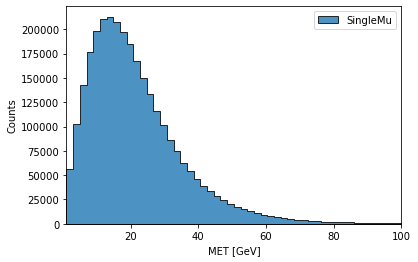

In [4]:
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all muons 74439173
final events 2970885
